# Imports

In [1]:
%matplotlib inline

import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
sys.path.append("../models/slim")
# Tensorflow
import tensorflow as tf
slim = tf.contrib.slim
from nets import inception
from preprocessing import inception_preprocessing
from datasets import imagenet
# Third-party
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import numpy as np
import time
# LIME
from lime import lime_image

from __future__ import absolute_import
from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file
from keras import backend as K
import imageio

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


# CIFAR Data Import

In [2]:
DATA_DIR = '../data/cifar_10/'

def load_data(data_dir):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
#     dirname = '../data/cifar_10/'
#     origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
#     path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(data_dir, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(data_dir, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

#     if K.image_data_format() == 'channels_last':
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data(DATA_DIR)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

img_idx = np.random.randint(0,10000, size=(1))

# Initializations

In [3]:
session_inception = tf.Session()
session_resnet = tf.Session()

image_size_inception = inception.inception_v3.default_image_size
image_size_resnet = inception.inception_resnet_v2.default_image_size

In [4]:
# def transform_img_fn(path_list, image_size, session):
#     out = []
#     for f in path_list:
#         image_raw = tf.image.decode_jpeg(open(f).read(), channels=3)
#         print type(image_raw)
#         image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
#         out.append(image)
#     return session.run([out])[0]

def transform_img_fn(image_rgb, image_size, session):
    out = []
    f = imageio.imwrite(uri=imageio.RETURN_BYTES, format='png', im=image_rgb)
    image_raw = tf.image.decode_png(f, channels=3)
    image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
    out.append(image)
    return session.run([out])[0]

In [5]:
names = imagenet.create_readable_names_for_imagenet_labels()
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [6]:
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits_inception, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities_inception = tf.nn.softmax(logits_inception)

with slim.arg_scope(inception.inception_resnet_v2_arg_scope()):
    logits_resnet, _ = inception.inception_resnet_v2(processed_images, num_classes=1001, is_training=False)
probabilities_resnet = tf.nn.softmax(logits_resnet)

In [7]:
checkpoints_dir = "../models/slim/pretrained"

init_fn_inception = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, "inception_v3.ckpt"),
    slim.get_model_variables("InceptionV3"))
init_fn_inception(session_inception)

init_fn_resnet = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, "inception_resnet_v2.ckpt"),
    slim.get_model_variables("InceptionResnetV2"))
init_fn_resnet(session_resnet)

In [8]:
def predict_fn_inception(images):
    return session_inception.run(probabilities_inception, feed_dict={processed_images: images})

def predict_fn_resnet(images):
    return session_resnet.run(probabilities_resnet, feed_dict={processed_images: images})

# Base Classifier and Lime explanations for top 5 Classes

In [ ]:
indir = '../data/image_input/'

for idx in img_idx[:1]:
        print('Id = ' + str(idx))
        print('  True Class = ' + str(y_train[idx][0]))
        
        # Base Classifiers
        images_inception = transform_img_fn(X_train[idx], image_size_inception, session_inception)
        preds_inception = predict_fn_inception(images_inception)
        preds_inception_top = preds_inception.argsort()[0][-1]
        print('  Inception: ' + str(preds_inception_top))
        
        images_resnet = transform_img_fn(X_train[idx], image_size_resnet, session_resnet)
        preds_resnet = predict_fn_resnet(images_resnet)
        preds_resnet_top = preds_resnet.argsort()[0][-1]
        print('  Resnet: ' + str(preds_resnet_top))
        

        # Lime Explainers
        image_inception = images_inception[0]
        explainer_inception = lime_image.LimeImageExplainer()
        explanation_inception = explainer_inception.explain_instance(image_inception, 
                                                                     predict_fn_inception, 
                                                                     top_labels=5, 
                                                                     hide_color=0, 
                                                                     num_samples=1000)
        
        image_resnet = images_resnet[0]
        explainer_resnet = lime_image.LimeImageExplainer()
        explanation_resnet = explainer_resnet.explain_instance(image_resnet, 
                                                               predict_fn_resnet, 
                                                               top_labels=5, 
                                                               hide_color=0, 
                                                               num_samples=1000)
        
        
        # Explanations for the top class
        temp_inception, mask_inception = explanation_inception.get_image_and_mask(preds_inception_top, 
                                                                                  positive_only=False, 
                                                                                  num_features=5, 
                                                                                  hide_rest=False)
        temp_resnet, mask_resnet = explanation_resnet.get_image_and_mask(preds_resnet_top, 
                                                                         positive_only=False, 
                                                                         num_features=5, 
                                                                         hide_rest=False)
        

# Plots

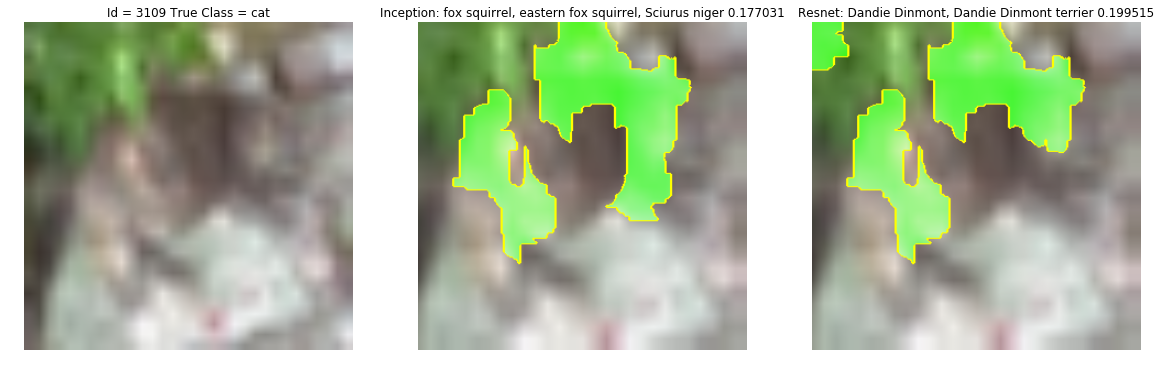

In [14]:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,60))
        ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
        
        ax1.imshow(X_train[idx])
        ax1.set_title('Id = ' + str(idx) + ' True Class = ' + str(class_names[y_train[idx][0]]))
        
        ax2.imshow(mark_boundaries(temp_inception / 2 + 0.5, mask_inception))
        ax2.set_title('Inception: ' 
                      + str(names[preds_inception_top]) 
                      + str(' ') 
                      + str(preds_inception[0,preds_inception_top]))

        ax3.imshow(mark_boundaries(temp_resnet / 2 + 0.5, mask_resnet))
        ax3.set_title('Resnet: ' 
                      + str(names[preds_resnet_top])
                      + str(' ') 
                      + str(preds_resnet[0,preds_resnet_top]))